## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

import statsmodels.api as sm

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df['user_id'].count()

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df['user_id'].count() - df.query('group == "treatment" and landing_page == "new_page" or group == "control" and landing_page == "old_page"')['user_id'].count()

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query('group == "treatment" and landing_page == "new_page" or group == "control" and landing_page == "old_page"')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(['user_id'], keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates(subset = 'user_id')

In [14]:
df2[df2.duplicated(['user_id'], keep = False)]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"')['user_id'].count()/df2['user_id'].count()

0.5000619442226688

In [19]:
num_conv_treat = df2.query('group == "treatment" and converted == 1').count()[0]
num_conv_control = df2.query('group == "control" and converted == 1').count()[0]

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Results:**

- The probability of converting regardless of the page is 11.96%
- Given an individual received the control page, the probability of converting is 12.04%
- Given that an individual received the treatment page, the probability of converting is 11.88%
- The probability of receiving the new page is 50.01%

***From the above stats, we don't have enough evidence to conclude that the new treatment page leads to more conversions than the old page. This can be stated with the help of the probabilities of converting in the control group and the treatment group being close to each other, with a difference of 0.16%.***

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

***H0 : P_new - P_old <=0***

***H1 : P_new - P_old > 0***

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2.query('converted == 1').user_id.count()/df2.user_id.count()
print('p new convert rate: ', p_new)

p new convert rate:  0.11959708724499628


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2.query('converted == 1').user_id.count()/df2.user_id.count()
print('p old convert rate: ', p_old)

p old convert rate:  0.11959708724499628


c. What is $n_{new}$?

In [22]:
n_new = df2.query('landing_page == "new_page"')['user_id'].count()
print('n new: ', n_new)

n new:  145310


d. What is $n_{old}$?

In [23]:
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
print('n old: ', n_old)

n old:  145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([1,0], size = n_new, replace = True, p = [p_new, 1-p_new])
print(new_page_converted)
print(new_page_converted.sum())

[0 1 0 ... 0 0 0]
17442


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([1,0], size = n_old, replace = True, p = [p_old, 1-p_old ])
print(old_page_converted)
print(old_page_converted.sum())

[0 1 0 ... 0 0 0]
17341


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
print("New page converted mean: ", new_page_converted.mean())
print("Old page converted mean: ", old_page_converted.mean())
print("p new - p old: ", new_page_converted.mean() - old_page_converted.mean())

New page converted mean:  0.1200330328263712
Old page converted mean:  0.11936753995897408
p new - p old:  0.00066549286739713


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1,0], size = n_new, replace = True, p = (p_new, 1-p_new))
    old_page_converted = np.random.choice([1,0], size = n_old, replace = True, p =(p_old, 1-p_old))
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  16.,  150.,  621., 1654., 2610., 2600., 1606.,  586.,  141.,
          16.]),
 array([-4.29698143e-03, -3.43250839e-03, -2.56803534e-03, -1.70356229e-03,
        -8.39089249e-04,  2.53837976e-05,  8.89856844e-04,  1.75432989e-03,
         2.61880294e-03,  3.48327598e-03,  4.34774903e-03]),
 <a list of 10 Patch objects>)

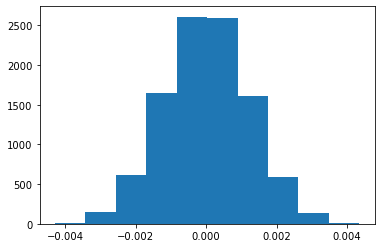

In [28]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
p_actual_old = df2.query("group == 'control'").converted.mean()
p_actual_new = df2.query("group == 'treatment'").converted.mean()
actual_diff = p_actual_new - p_actual_old
print("Number of converted persons in control group: ", num_conv_control, "; P old: ", p_actual_old)
print("Number of converted persons in treatment group: ", num_conv_treat, "; P new: ", p_actual_new)
print("Actual Difference: ", actual_diff)

Number of converted persons in control group:  17489 ; P old:  0.1203863045004612
Number of converted persons in treatment group:  17264 ; P new:  0.11880806551510564
Actual Difference:  -0.0015782389853555567


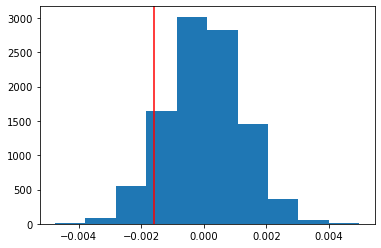

In [30]:
p_diffs = np.array(p_diffs)
#Calculating the null_val based on the std of the p_diffs array
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals)
plt.axvline(actual_diff, color = 'red')

In [31]:
(null_vals > actual_diff).mean()

0.9022

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

***In j, we calculated the p-value with 0.9043***

***We assume that the null hypothesis is true and p_old = p_new, i.e., both pages have the same converting rates over the whole sample. We bootstrapped a sampling distribution for both pages and calculated the differences in converting probability per page with n equal to the original number of people who received each page with a converting probability of 0.1195. We then calculated the values from a normal distribution around 0 using the resulting standard deviation of the differences. In the end, the proportion of values bigger than the actually oberserved difference is calculated. The new calculated p-value tells us the probability of receiving this observed statistics if the null hypothesis is true.***

***With a Type-I-Error rate of 0.05, we can say that 0.9095 > 0.05. So, we don't have enough evidence to reject the null hypothesis.***

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2.query("group == 'control'").converted.sum()
convert_new = df2.query("group == 'treatment'").converted.sum()
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new = df2.query('landing_page == "new_page"').count()[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
from scipy.stats import norm

# Calculate Z-Test
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = "smaller")

# Calculate the Critical Z-Term
z_critical = norm.ppf(1-(0.05))

print("Z-Score: ", z_score, "\nCritical Z-Score: ", z_critical, "\nP-Value: ", p_value)

Z-Score:  1.3109241984234394 
Critical Z-Score:  1.6448536269514722 
P-Value:  0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

***The p-value obtained validates our findings in j. Also, the calculates Z-Score is smaller than the Critical Z-Score. Hence, we fail to reject the null hypothesis based on the Z-Test, i.e., the conversion rates of the old page is equal or better than the conversion rates of the new page***

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

***For a binary case, Logistic Regression should be performed.***

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df_log = df2.copy()
df_log.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [35]:
df_log["intercept"] = 1

# performing one hot encoding
df_log = df_log.join(pd.get_dummies(df_log['group']))
df_log.rename(columns = {"treatment" : "ab_page"}, inplace = True)

In [36]:
df_log.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [37]:
y = df_log["converted"]
x = df_log[["intercept", "ab_page"]]

# Load the model
log_mod = sm.Logit(y,x)

# Fit the model
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:               8.077e-06
Time:                        01:00:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

***The p-value in the model in Part III is different from the other p-value I calculated during the Part II because of the two different approach of the calculation. The p-value in the Part II suggest how likely are our data assuming a true null hypothesis. The p-value is quite high in the Part II what suggesting that we fail to reject the null.***

***In part III, the p-value associated with the alternative hypothesis is the P>|z| value of ab_page in the model. This value tests if the paramater of the slope (or in the intercept) is equal to null hypothesis and suggest whether the changes in the explanatory variables are related to changes to the response variable (here: converted). A low p-value means that the predictors are very significant to the changes. This p-value is too high to reject the null hypothesis, reflecting that the changes in the explanatory are not associated with the changes in the response value.***

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

***It would be a good idea to add the time duration the users spent with the page. The more time the customer spends with a page the more likely to get used to it and get engaged. Age or location could be also a good thing to consider because there can be big differences among the preferences of different age groups and locations.***

***However, many additional term could confuse our analysis and lead to a model which is hard to follow. Besides, too many factors could result a situation when more term has less significant impact on the outcome. The better method is to stick to the thing that have a big influence on the conversion probability.***

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
df_countries = pd.read_csv("countries.csv")
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
#merge the dataframes together
df_log_country = df_log.merge(df_countries, on="user_id", how = "left")

In [41]:
df_log_country = df_log_country.join(pd.get_dummies(df_log_country['country']))
df_log_country.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
y = df_log_country["converted"]
x = df_log_country[["intercept", "ab_page", "CA", "UK"]]

log_mod = sm.Logit(y,x)
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:               2.323e-05
Time:                        01:00:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [43]:
print("ab_page reciprocal exponential: ", 1/np.exp(-0.0149), "-", "A conversion is 1.015 times less likely, if a user receives the treatment page, holding all other variables constant\n"
      "\nCA reciprocal exponential: ", 1/np.exp(-0.0408), "-", "A conversion is 1.042 times less likely, if the user lives in CA and not the US.\n"
      "\nUK exponential: ",np.exp(0.0099),"-", "A conversion is 1.00995 times more likely, if the user lives in UK and not the US.")

ab_page reciprocal exponential:  1.0150115583846535 - A conversion is 1.015 times less likely, if a user receives the treatment page, holding all other variables constant

CA reciprocal exponential:  1.0416437559600236 - A conversion is 1.042 times less likely, if the user lives in CA and not the US.

UK exponential:  1.0099491671175422 - A conversion is 1.00995 times more likely, if the user lives in UK and not the US.


In [44]:
df_log_country.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1


In [45]:

#create the interaction higher order term for the ab_page and country columns
df_log_country["CA_page"], df_log_country["UK_page"] = df_log_country["CA"] * df_log_country["ab_page"], df_log_country["UK"] * df_log_country["ab_page"]

In [46]:
df_log_country.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US,CA_page,UK_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1,0,0


In [47]:
y = df_log_country["converted"]
x = df_log_country[["intercept", "ab_page", "CA", "UK", "CA_page", "UK_page"]]

log_mod = sm.Logit(y,x)
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:               3.482e-05
Time:                        01:00:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

***Based on these results, we can see that the p_values for the interaction terms are definietly not significant and even decrease the significance of the original "CA" and "UK" columns. Therefore we should not include these higher order terms in our model.***

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.